In [1]:
from config.regtest_04 import config
config

2024-02-06 15:21:56.505352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'threshold': 1.5,
 'datapath': '../../../climate/sim-data/preproc/',
 'filenames_sims': ['tas_anual_preproc_ssp126_ACCESS-ESM1-5.nc',
  'tas_anual_preproc_ssp126_CanESM5.nc',
  'tas_anual_preproc_ssp126_MIROC-ES2L.nc',
  'tas_anual_preproc_ssp126_MIROC6.nc',
  'tas_anual_preproc_ssp126_UKESM1-0-LL.nc',
  'tas_anual_preproc_ssp245_ACCESS-ESM1-5.nc',
  'tas_anual_preproc_ssp245_CNRM-ESM2-1.nc',
  'tas_anual_preproc_ssp245_CanESM5.nc',
  'tas_anual_preproc_ssp245_GISS-E2-1-G.nc',
  'tas_anual_preproc_ssp245_IPSL-CM6A-LR.nc',
  'tas_anual_preproc_ssp245_MIROC-ES2L.nc',
  'tas_anual_preproc_ssp370_ACCESS-ESM1-5.nc',
  'tas_anual_preproc_ssp370_CESM2.nc',
  'tas_anual_preproc_ssp370_CanESM5.nc',
  'tas_anual_preproc_ssp370_GISS-E2-1-G.nc',
  'tas_anual_preproc_ssp370_IPSL-CM6A-LR.nc',
  'tas_anual_preproc_ssp370_MIROC-ES2L.nc',
  'tas_anual_preproc_ssp370_UKESM1-0-LL.nc'],
 'context': 'ssp&model&prior',
 'informative_prior': {'type': 'truncated-normal', 'mean': 10, 'std': 10},
 'year_bounds

In [2]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow/')))
sys.path.append(os.path.abspath(os.path.join('../..')))  # access sibling directories
from src.python.helpers import _configure_input, format_names, estimate_data_means_and_stds
from src.python.visualization import build_climate_model_color_dict

from setup import *

/home/ho/code/BayesFlow/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
RNG = np.random.default_rng(config['rng_seed'])

In [4]:
DATAPATH = config['datapath']
datasets = load_datasets(config, data_path=DATAPATH)
model_names = list(datasets.keys())

model = build_generative_model(config, datasets, RNG)

train_data_dict = OrderedDict((key, datasets[key].TAS.isel(member=config['member_split']['train']) - datasets[key].TAS_baseline) for key in datasets.keys())
data_means, data_stds = estimate_data_means_and_stds(train_data_dict)
prior_means, prior_stds = model.prior.estimate_means_and_stds()

context_aware = config['context_aware'] if 'context_aware' in config else True
configure_input = partial(_configure_input, prior_means=prior_means, prior_stds=prior_stds, data_means=data_means, data_stds=data_stds, context=config['context'], context_aware=context_aware)

amortizer = build_amortizer(config)

trainer = Trainer(
    amortizer=amortizer, configurator=configure_input, checkpoint_path=config['checkpoint_path'],
    generative_model=model, memory=True, reuse_optimizer=True,
)

INFO:root:Using uniform and truncated normal, (10, 10), prior on time-to-threshold between -40 and 41.
INFO:root:Using the following climate models: ['ssp126_ACCESS-ESM1-5', 'ssp126_CanESM5', 'ssp126_MIROC-ES2L', 'ssp126_MIROC6', 'ssp126_UKESM1-0-LL', 'ssp245_ACCESS-ESM1-5', 'ssp245_CNRM-ESM2-1', 'ssp245_CanESM5', 'ssp245_GISS-E2-1-G', 'ssp245_IPSL-CM6A-LR', 'ssp245_MIROC-ES2L', 'ssp370_ACCESS-ESM1-5', 'ssp370_CESM2', 'ssp370_CanESM5', 'ssp370_GISS-E2-1-G', 'ssp370_IPSL-CM6A-LR', 'ssp370_MIROC-ES2L', 'ssp370_UKESM1-0-LL']
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 72, 144)
INFO:root:No optional prior non-batchable context provided.
INFO:root:Could not determine shape of prior batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurat

In [5]:
history = trainer.loss_history.get_plottable()

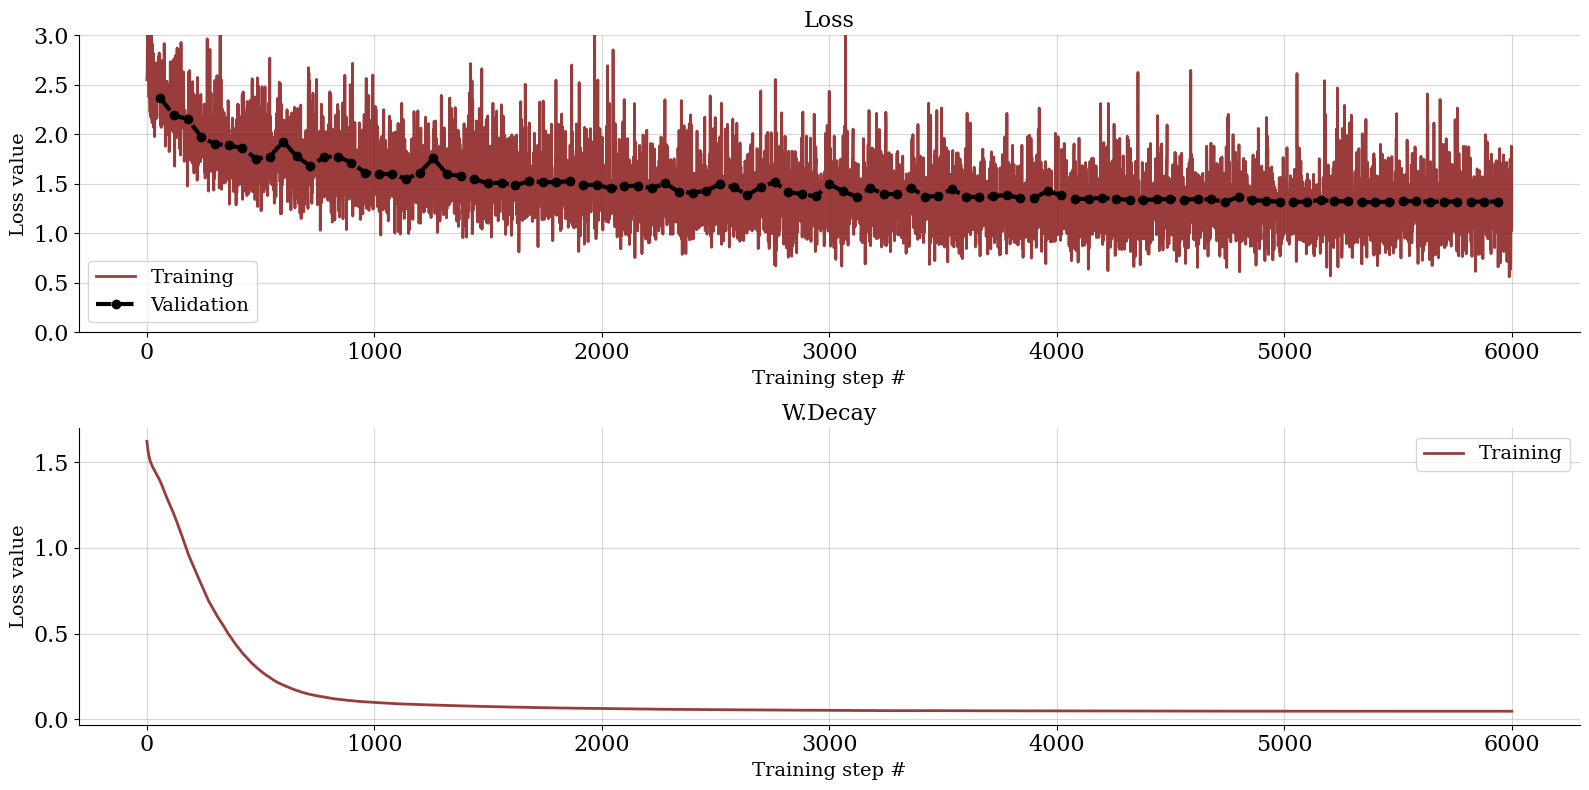

In [6]:
f = diag.plot_losses(history["train_losses"], history["val_losses"])
# constrain the y-axis to be between 0 and 3
f.axes[0].set_ylim(0, 3)
f.savefig(os.path.join(config['checkpoint_path'], 'climate_losses.pdf'), bbox_inches='tight')

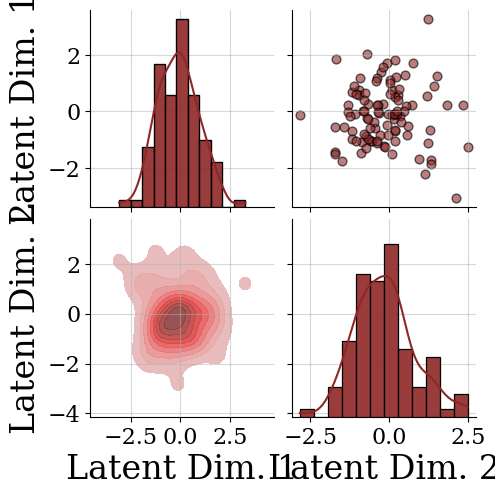

In [7]:
val_sims = model(100, sim_args= {'state':'val'})
f = trainer.diagnose_latent2d(val_sims)

## Mean Absolute Error

To validate the accuracy of the models, we compute the mean absolute error. 

To compare with Diffenbaugh and Barnes method that works on the marginal distribution, we can marginalize predictions over different climate model contexts.

First, with the help of the generative model as an interface to the simulated datasets:

In [8]:
metrics = {}    # keep track of metrics for this run

# To speed up the validation process, we can use pre-simulated train and validation data. If the path to the pre-simulated data is
# not provided in the config, we will simulate the data here. If the path is provided, we will load the data and compute
# the loss.

try:
    if not 'presimulate_path' in config.keys():
        raise KeyError("No presimulate_path in config")

    for state in ['train', 'val']:
        sims_path = os.path.join(config['presimulate_path'], f'presim_{state}.pkl')
        if not os.path.exists(sims_path):
            raise FileNotFoundError(f"Could not find pre-simulated data at {sims_path}")

        sims = np.load(sims_path, allow_pickle=True)
        data = trainer.configurator(sims)
        loss = amortizer.compute_loss(data).numpy()

        metrics[f'{state}_loss'] = {'mean':loss, 'std':None}
        print(f"{state.capitalize()} loss: {loss:.3f}")

        # name in same format as freshly simulated data
        if state == 'train':
            train_data = data
        elif state == 'val':
            val_data = data
        else:
            raise ValueError(f"Unknown state: {state}")

# if no pre-simulated data is available, simulate it here
except (KeyError, FileNotFoundError) as e:
    # Generate and compute loss for train data
    train_loss_batches = []
    train_data_list = []
    for _ in range(10):
        sims_train = trainer.generative_model(batch_size=100, sim_args={'state': 'train'})
        batch_train_data = trainer.configurator(sims_train)
        train_loss_batches.append(amortizer.compute_loss(batch_train_data).numpy())
        train_data_list.append(batch_train_data)

    train_data = {}
    for key in train_data_list[0].keys(): # concatenate the data from the different batches
        train_data[key] = np.concatenate([train_data_list[i][key] for i in range(len(train_data_list))], axis=0)

    metrics['train_loss'] = {'mean': np.mean(train_loss_batches), 'std': np.std(train_loss_batches)}
    print(f"Train loss: {metrics['train_loss']['mean']:.3f} ± {metrics['train_loss']['std']:.3f}")
    del sims_train, batch_train_data    # free up memory


    # Generate and compute loss for validation data
    val_loss_batches = []
    val_data_list = []
    for _ in range(10):
        sims_val = trainer.generative_model(batch_size=500, sim_args={'state': 'val'})
        batch_val_data = trainer.configurator(sims_val)
        val_loss_batches.append(amortizer.compute_loss(batch_val_data).numpy())
        val_data_list.append(batch_val_data)

    val_data = {}
    for key in val_data_list[0].keys(): # concatenate the data from the different batches
        val_data[key] = np.concatenate([val_data_list[i][key] for i in range(len(val_data_list))], axis=0)

    metrics['val_loss'] = {'mean': np.mean(val_loss_batches), 'std': np.std(val_loss_batches)}
    print(f"Val loss:   {metrics['val_loss']['mean']:.3f} ± {metrics['val_loss']['std']:.3f}")
    del sims_val, batch_val_data    # free up memory

Train loss: 1.079
Val loss: 1.320


In [9]:
train_data['summary_conditions'].shape, val_data['summary_conditions'].shape

((5000, 72, 144), (5000, 72, 144))

In [10]:
def calculate_MAE_gm(val_data, amortizer, prior_means, prior_stds, climate_model_aware, use_informative_prior=False):

    sc = val_data['summary_conditions']
    dc = val_data['direct_conditions']
    param = val_data['parameters']

    if use_informative_prior:
        prior_mask = dc[:,-1] == 1
    else:
        prior_mask = dc[:,-1] == 0 # all flat prior true

    sc = sc[prior_mask]
    dc = dc[prior_mask]
    param = param[prior_mask]

    MAEs = {}
    df = pd.DataFrame(columns=['SSP + Climate Model', 'true_theta', 'mean_theta'])

    ssp_index_ranges = [(0, 5), (5, 11), (11, 18)]
    for sspi, ssp_range in enumerate(ssp_index_ranges):

        mask = np.logical_and(dc.argmax(axis=1) >= ssp_range[0], dc.argmax(axis=1) < ssp_range[1]) # all in sspi true
        sc_ssp = sc[mask]
        dc_ssp = dc[mask]
        param_ssp = param[mask]

        a = np.eye(18)[slice(*ssp_range)]
        n_models_in_ssp = int(a.sum())

        if use_informative_prior:
            dc_unique = np.concatenate((a, np.ones((n_models_in_ssp,1))), axis=1)
        else:
            dc_unique = np.concatenate((a, np.zeros((n_models_in_ssp,1))), axis=1)

        if climate_model_aware:
            dc_rep = np.repeat(dc_ssp, n_models_in_ssp, axis=0)
        else:
            dc_rep = np.tile(dc_unique, (sc_ssp.shape[0],1))

        sc_rep = np.repeat(sc_ssp, n_models_in_ssp, axis=0)
        param_rep = np.repeat(param_ssp, n_models_in_ssp, axis=0)

        rep_val_data = {
                'summary_conditions': sc_rep,
                'direct_conditions': dc_rep,
                'parameters': param_rep,
        }

        rep_samples = amortizer.sample(
            rep_val_data,
            n_samples=100,
            to_numpy=True,
        )

        param_marg = rep_val_data['parameters'].reshape((n_models_in_ssp,-1,2), order='F').mean(axis=0)
        rep_samples_marg = rep_samples.reshape((n_models_in_ssp,-1,100,2), order='F').mean(axis=0)

        mean_ttt = np.array(rep_samples_marg.mean(axis=1)*prior_stds + prior_means)[:,0]
        true_ttt = np.array(param_marg *prior_stds + prior_means)[:,0]
        assert mean_ttt.shape == true_ttt.shape
        MAE = np.mean(np.abs(mean_ttt - np.round(true_ttt)))
        print(f'SSP{sspi+1}', 'Mean absolute error (years):', round(MAE,1))

        MAEs['ssp'+str(sspi+1)] = MAE

        df = pd.concat([df, pd.DataFrame({
                'SSP + Climate Model': np.array([format_names(mn) for mn in model_names])[dc_ssp.argmax(axis=1)],
                'true_theta': param_marg[:,0]*prior_stds[:,0] + prior_means[:,0],
                'mean_theta': rep_samples_marg.mean(axis=1)[:,0]*prior_stds[:,0] + prior_means[:,0],
            })])

    # average over all SSPs taking into account the number of models in each SSP
    n_models_in_ssp = np.diff(ssp_index_ranges, axis=1).squeeze()
    MAEs['average'] = np.sum(( np.array(list(MAEs.values())) * n_models_in_ssp ) / n_models_in_ssp.sum())
    print('Average', 'Mean absolute error (years):', round(MAEs['average'],1))

    return MAEs, df

In [11]:
def prepare_columns(df):
    df_prep = df.copy()
    df_prep['SSP'] = df_prep['SSP + Climate Model'].apply(lambda x: x.split(' ')[0])
    df_prep['Climate Model'] = df_prep['SSP + Climate Model'].apply(lambda x: x.split(' ')[1])
    df_prep.sort_values(by='Climate Model', inplace=True)
    return df_prep

def plot_MAEs(df, MAEs, palette):
    g = sns.FacetGrid(df, hue='Climate Model', col='SSP', palette=palette, height=4, aspect=0.9, sharex=True, sharey=True, legend_out=True, col_order=np.sort(df['SSP'].unique()))


    for sspi, ax in enumerate(g.axes.flatten()):
        ax.plot(np.arange(-50, 50), np.arange(-50, 50), 'k--', alpha=0.5, zorder=0)
        if MAEs is not None:
            #ssp_mae = np.mean([MAEs[ds_name] for ds_name in model_names if f'ssp{sspi+1}' in ds_name])# and 'MIROC6' in ds_name])
            ax.text(0.95, 0.05, f"MAE: {round(MAEs['ssp'+str(sspi+1)], 1)}", transform=ax.transAxes, va='bottom', ha='right', fontsize=16)

    g.map_dataframe(sns.scatterplot, x='true_theta', y='mean_theta', alpha=0.3, s=30, zorder=5)
    g.set(xlim=(-50, 50), ylim=(-50, 50), xticks=[-40, 0, 40], yticks=[-40, 0, 40])
    # replace axis labels with latex
    g.set_axis_labels(r'$\theta_{1.5^\circ C}^*$', r'$\hat{\theta}_{1.5^\circ C}$')
    # add perfect prediction line
    g.set_titles("{col_name}")
    g.add_legend(markerscale=2)
    plt.show()
    return g

def plot_MAE_overview(df, MAEs):

    df = prepare_columns(df)

    model_colors = build_climate_model_color_dict(df['Climate Model'].unique())
    palette = sns.color_palette(list(model_colors.values()))

    g = plot_MAEs(df, MAEs, palette)
    return g

Climate model aware
Informative prior
SSP1 Mean absolute error (years): 2.1
SSP2 Mean absolute error (years): 2.0
SSP3 Mean absolute error (years): 1.8
Average Mean absolute error (years): 2.0


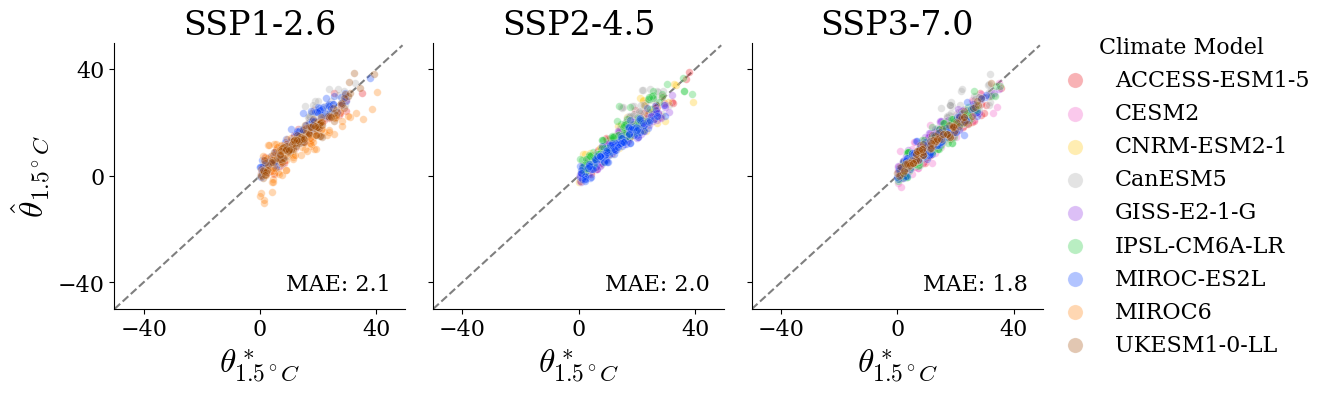

----
Climate model aware
Flat prior
SSP1 Mean absolute error (years): 3.7
SSP2 Mean absolute error (years): 2.7
SSP3 Mean absolute error (years): 2.4
Average Mean absolute error (years): 2.9


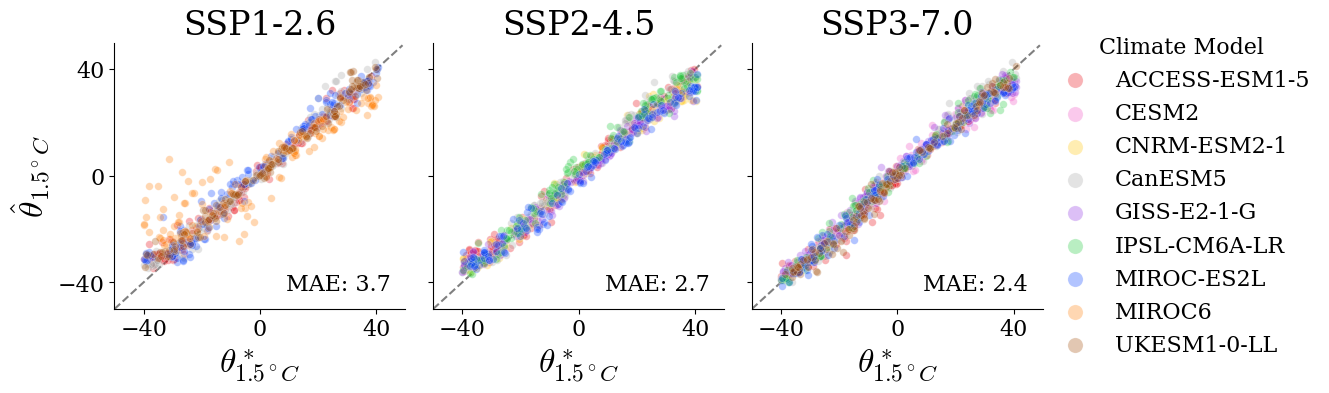

----
Climate model unaware
Informative prior
Informative prior currently not available for climate model unaware
Climate model unaware
Flat prior
SSP1 Mean absolute error (years): 3.8
SSP2 Mean absolute error (years): 2.8
SSP3 Mean absolute error (years): 2.4
Average Mean absolute error (years): 2.9


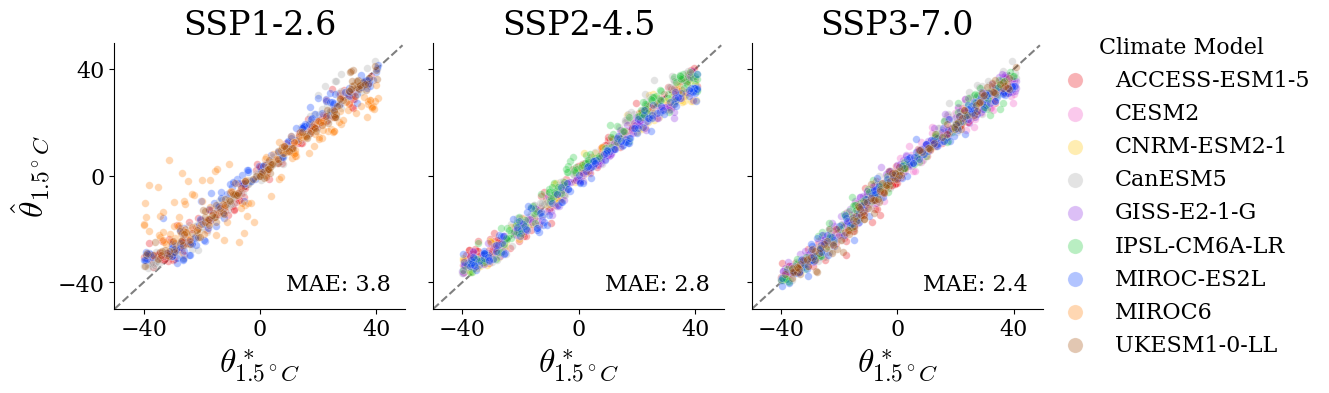

----


In [12]:
# calculate mean absolute error and plot recovery. First for test data

for climate_model_aware in [True, False]:
    for use_informative_prior in [True, False]:

        if climate_model_aware:
            print('Climate model aware')
            file_name = 'climate-MAE_cm_aware'
        else:
            print('Climate model unaware')
            file_name = 'climate-MAE_cm_unaware'

        if use_informative_prior:
            print('Informative prior')
            file_name += '_infoprior'
            if not climate_model_aware:
                print('Informative prior currently not available for climate model unaware')
                continue
        else:
            print('Flat prior')
            file_name += '_flatprior'

        MAEs, df = calculate_MAE_gm(train_data, amortizer, prior_means, prior_stds, climate_model_aware=climate_model_aware, use_informative_prior=use_informative_prior)
        #metrics[f'MAEs_{climate_model_aware}_{use_informative_prior}'] = MAEs
        file_name += f"_{MAEs['average'].round(1)}.pdf"
        g = plot_MAE_overview(df, MAEs)
        #g.savefig(os.path.join(config['checkpoint_path'], str(file_name)), bbox_inches='tight')
        #print('Saved to', os.path.join(config['checkpoint_path'], str(file_name)))
        print('----')

Climate model aware
Informative prior
SSP1 Mean absolute error (years): 2.7
SSP2 Mean absolute error (years): 3.0
SSP3 Mean absolute error (years): 2.7
Average Mean absolute error (years): 2.8


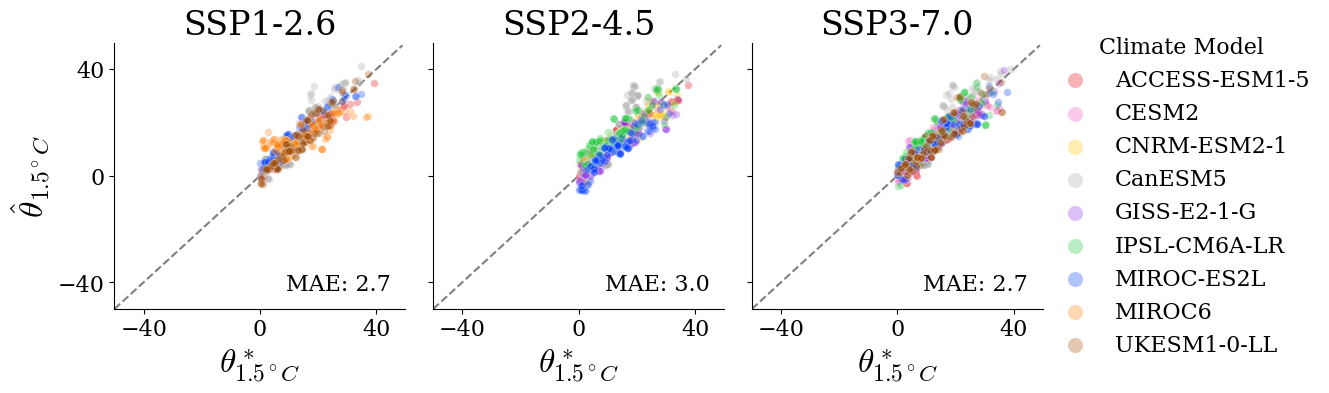

Saved to checkpoints/regtest_04/climate-MAE_cm_aware_infoprior_2.8.pdf
----
Climate model aware
Flat prior
SSP1 Mean absolute error (years): 4.9
SSP2 Mean absolute error (years): 3.6
SSP3 Mean absolute error (years): 2.9
Average Mean absolute error (years): 3.7


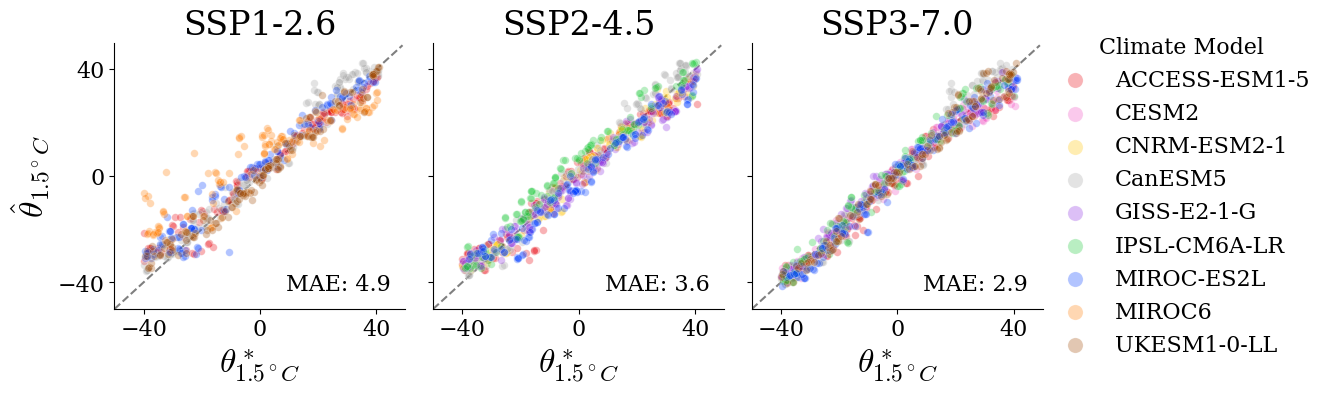

Saved to checkpoints/regtest_04/climate-MAE_cm_aware_flatprior_3.7.pdf
----
Climate model unaware
Informative prior
Informative prior currently not available for climate model unaware
Climate model unaware
Flat prior
SSP1 Mean absolute error (years): 5.0
SSP2 Mean absolute error (years): 3.7
SSP3 Mean absolute error (years): 3.0
Average Mean absolute error (years): 3.8


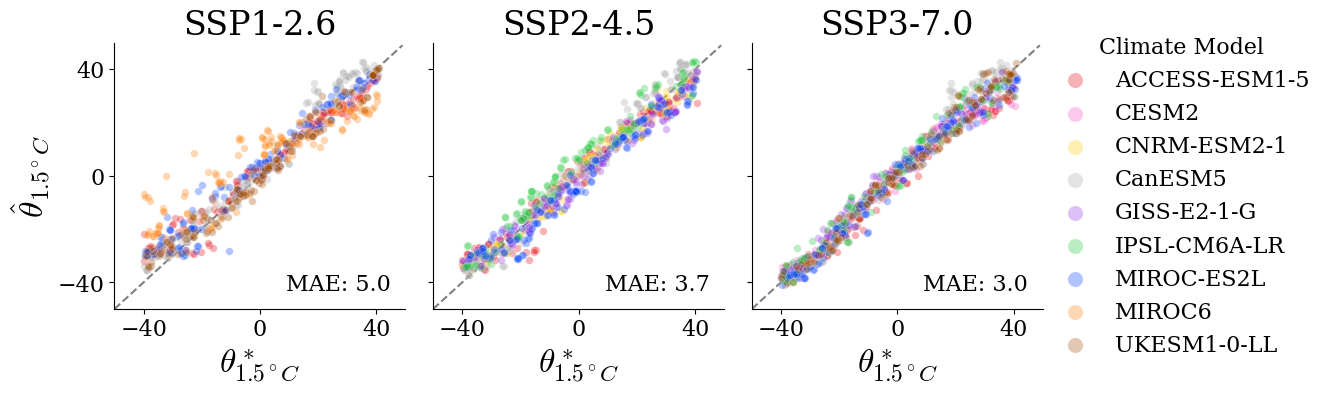

Saved to checkpoints/regtest_04/climate-MAE_cm_unaware_flatprior_3.8.pdf
----


In [13]:
# calculate mean absolute error and plot recovery. Now for unseen validation data

for climate_model_aware in [True, False]:
    for use_informative_prior in [True, False]:

        if climate_model_aware:
            print('Climate model aware')
            file_name = 'climate-MAE_cm_aware'
        else:
            print('Climate model unaware')
            file_name = 'climate-MAE_cm_unaware'

        if use_informative_prior:
            print('Informative prior')
            file_name += '_infoprior'
            if not climate_model_aware:
                print('Informative prior currently not available for climate model unaware')
                continue
        else:
            print('Flat prior')
            file_name += '_flatprior'

        MAEs, df = calculate_MAE_gm(val_data, amortizer, prior_means, prior_stds, climate_model_aware=climate_model_aware, use_informative_prior=use_informative_prior)
        metrics[f'MAEs_{climate_model_aware}_{use_informative_prior}'] = MAEs
        file_name += f"_{MAEs['average'].round(1)}.pdf"
        g = plot_MAE_overview(df, MAEs)
        g.savefig(os.path.join(config['checkpoint_path'], str(file_name)), bbox_inches='tight')
        print('Saved to', os.path.join(config['checkpoint_path'], str(file_name)))
        print('----')

# Calibration + ABI Recovery

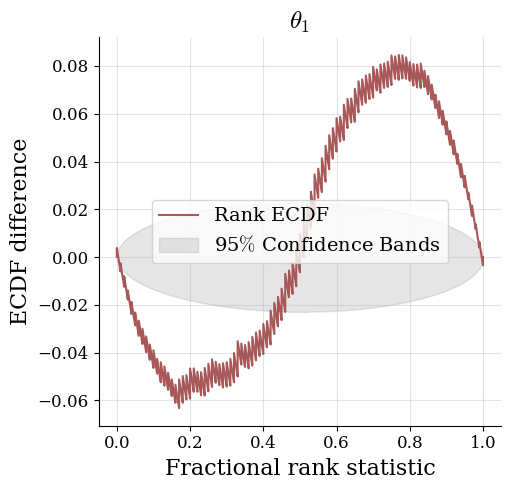

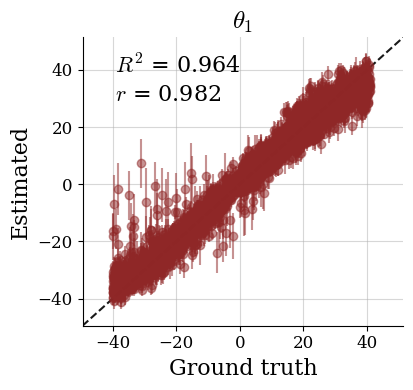

In [14]:
# Sample for each prior context
samples_train_data = amortizer.sample(
    train_data,
    n_samples=100,
    to_numpy=True,
)

f = diag.plot_sbc_ecdf(samples_train_data *prior_stds + prior_means,
                       train_data['parameters'] *prior_stds + prior_means, difference=True)
f.delaxes(f.axes[1])

f = diag.plot_recovery(samples_train_data *prior_stds + prior_means,
                       train_data['parameters'] *prior_stds + prior_means)
f.delaxes(f.axes[1])

In [15]:
# Filter based on prior context
val_data_informative = {}
for key, array in val_data.items():
    filtered_array = array[val_data["direct_conditions"][:, -1] == 1]
    val_data_informative[key] = filtered_array

val_data_flat = {}
for key, array in val_data.items():
    filtered_array = array[val_data["direct_conditions"][:, -1] == 0]
    val_data_flat[key] = filtered_array

In [16]:
# Sample for each prior context
samples_informative = amortizer.sample(
    val_data_informative,
    n_samples=100,
    to_numpy=True,
)

samples_flat = amortizer.sample(
    val_data_flat,
    n_samples=100,
    to_numpy=True,
)

In [17]:
# Unstandardize
post_samples_informative = np.array(samples_informative*prior_stds + prior_means)
prior_samples_informative = np.array(val_data_informative["parameters"] *prior_stds + prior_means)

post_samples_flat = np.array(samples_flat*prior_stds + prior_means)
prior_samples_flat = np.array(val_data_flat["parameters"] *prior_stds + prior_means)

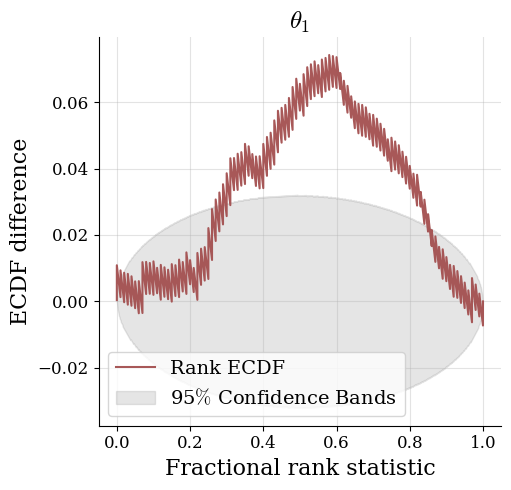

In [18]:
f = diag.plot_sbc_ecdf(post_samples_informative, prior_samples_informative, difference=True)
f.delaxes(f.axes[1])
f.savefig(os.path.join(config['checkpoint_path'], 'climate_sbc_ecdf_informative.pdf'), bbox_inches='tight')

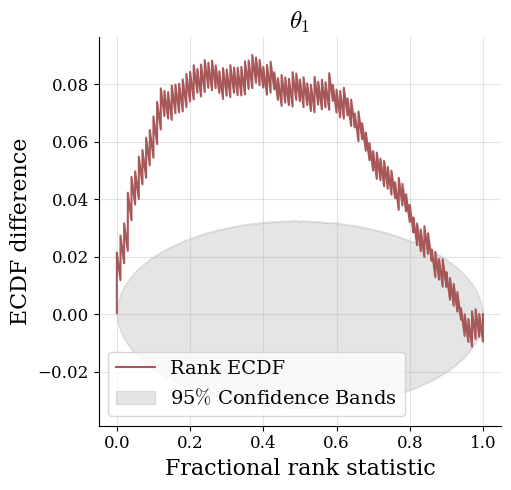

In [19]:
f = diag.plot_sbc_ecdf(post_samples_flat, prior_samples_flat, difference=True)
f.delaxes(f.axes[1])
f.savefig(os.path.join(config['checkpoint_path'], 'climate_sbc_ecdf_flat.pdf'), bbox_inches='tight')

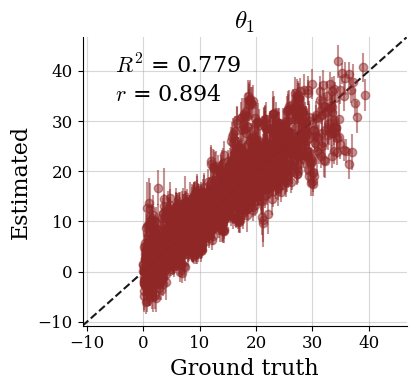

In [20]:
f = diag.plot_recovery(post_samples_informative, prior_samples_informative)
f.delaxes(f.axes[1])
f.savefig(os.path.join(config['checkpoint_path'], 'climate_recovery_informative.pdf'), bbox_inches='tight')

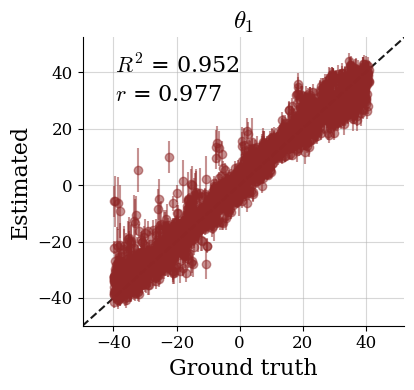

In [21]:
f = diag.plot_recovery(post_samples_flat, prior_samples_flat)
f.delaxes(f.axes[1])
f.savefig(os.path.join(config['checkpoint_path'], 'climate_recovery_flat.pdf'), bbox_inches='tight')

In [22]:
import pickle

# Export metrics
with open(os.path.join(config['checkpoint_path'], 'metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)
